In [31]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
labels_df = pd.read_csv('labels.csv')

In [48]:
data_dir = '/content/drive/MyDrive/traffic_Data/DATA'
images = []
labels = []

In [49]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [51]:
max_height = max(img.shape[0] for img in images)
max_width = max(img.shape[1] for img in images)


In [53]:
resized_images = []


In [54]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [55]:
images = np.array(resized_images)
labels = np.array(labels)

In [56]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
max_count = np.max(label_counts)

In [57]:
oversampled_images = []
oversampled_labels = []


In [58]:
for label, count in zip(unique_labels, label_counts):
    label_images = images[oversampled_labels == label]
    num_to_duplicate = max_count - count
    if num_to_duplicate > 0:

        oversampled_images.extend(label_images)
        oversampled_labels.extend([label] * num_to_duplicate)

In [59]:
print(images.shape , labels.shape)

(4170, 224, 224, 3) (4170,)


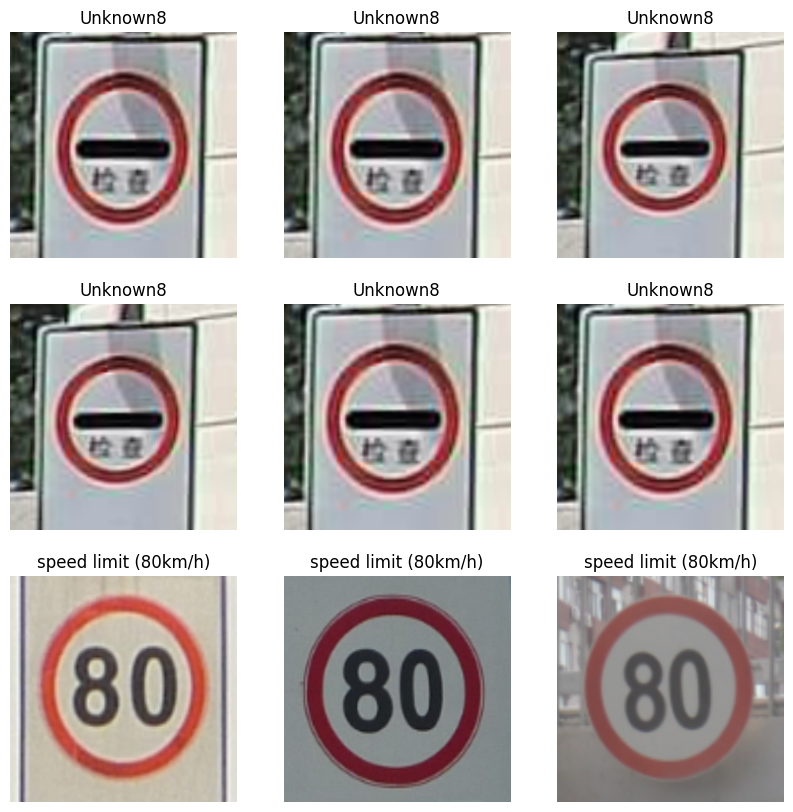

In [60]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

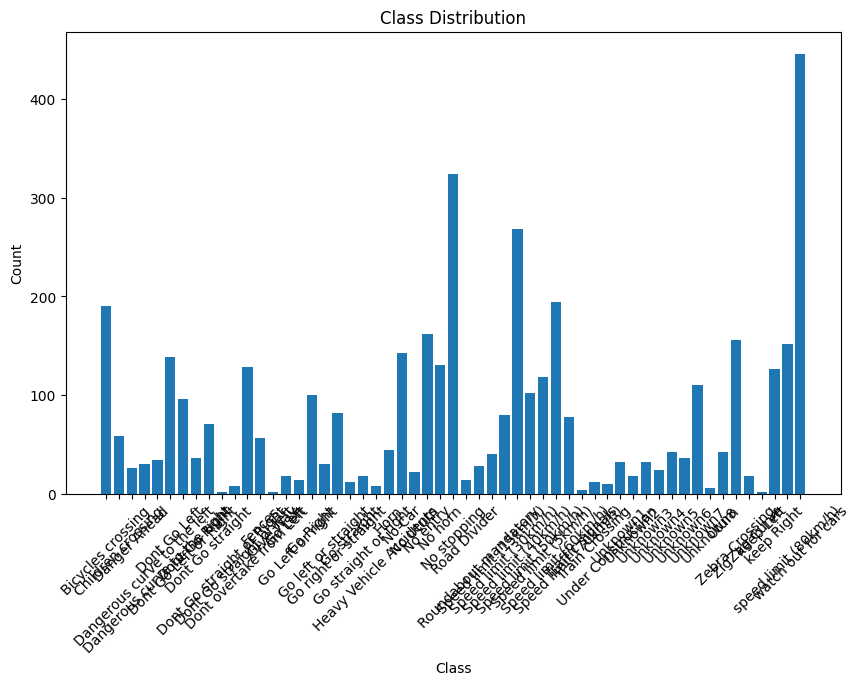

In [61]:
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


In [63]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [64]:
for layer in base_model.layers:
    layer.trainable = False

In [65]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(len(unique_labels), activation='softmax')(x)

In [66]:
mobile_model = Model(inputs=base_model.input, outputs=output)

In [67]:
mobile_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [68]:
checkpoint_path = "model_weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True,
                                      mode='min',
                                      save_freq='epoch')

In [69]:
X_resized = np.array(resized_images)

In [71]:
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)

In [75]:
from sklearn.preprocessing import LabelEncoder

In [76]:
label_encoder = LabelEncoder()


y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [77]:
history = mobile_model.fit(X_train_resized, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_resized, y_test_encoded),
                    callbacks=[checkpoint_callback])


test_loss, test_acc = mobile_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 1.7153 - accuracy: 0.5776
Epoch 1: val_loss improved from inf to 0.91732, saving model to model_weights.h5
105/105 [==============================] - 165s 2s/step - loss: 1.7153 - accuracy: 0.5776 - val_loss: 0.9173 - val_accuracy: 0.7482
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.8474
Epoch 2: val_loss improved from 0.91732 to 0.59157, saving model to model_weights.h5
105/105 [==============================] - 170s 2s/step - loss: 0.6082 - accuracy: 0.8474 - val_loss: 0.5916 - val_accuracy: 0.8405
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.9242
Epoch 3: val_loss improved from 0.59157 to 0.40947, saving model to model_weights.h5
105/105 [==============================] - 159s 2s/step - loss: 0.3296 - accuracy: 0.9242 - val_loss: 0.4095 - val_accuracy: 0.8801
Epoch 4/10
105/105 [==============================] - ETA: 0s - l

In [80]:
layer_outputs = [layer.output for layer in mobile_model.layers]
activation_model = Model(inputs=mobile_model.input, outputs=layer_outputs)
sample_image = X_train_resized[0:1]
activations = activation_model.predict(sample_image)


1/1 [==============================] - 1s 685ms/step


input_2 (1, 224, 224, 3)


<Figure size 640x480 with 0 Axes>

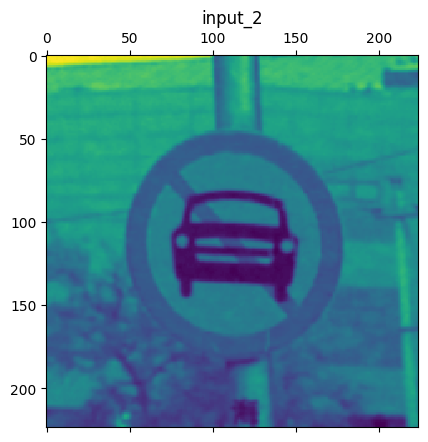

conv1 (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

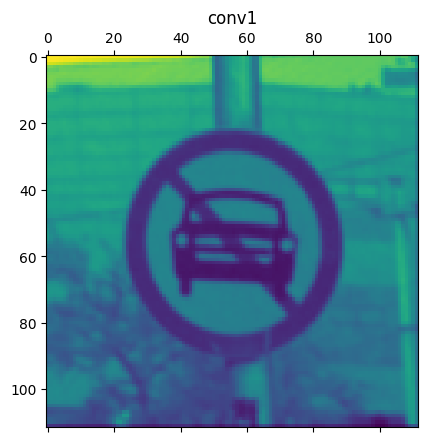

conv1_bn (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

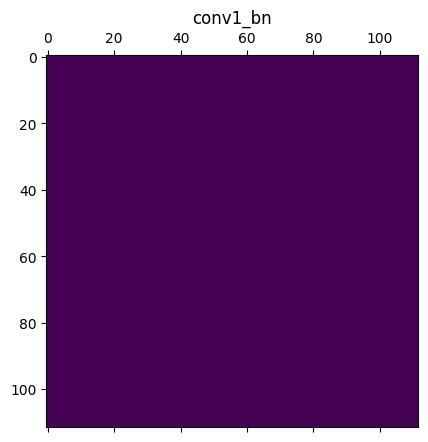

conv1_relu (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

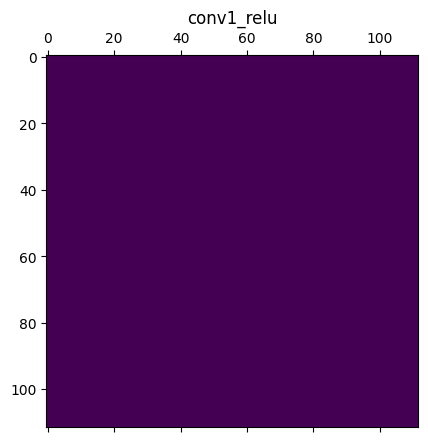

conv_dw_1 (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

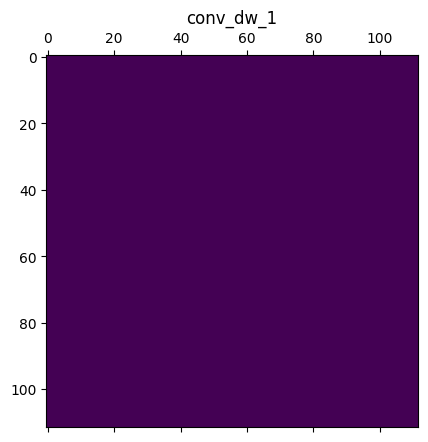

conv_dw_1_bn (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

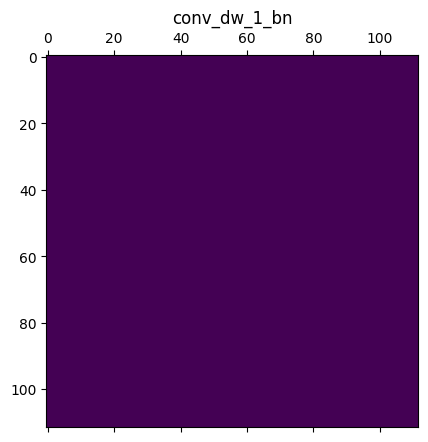

conv_dw_1_relu (1, 112, 112, 32)


<Figure size 640x480 with 0 Axes>

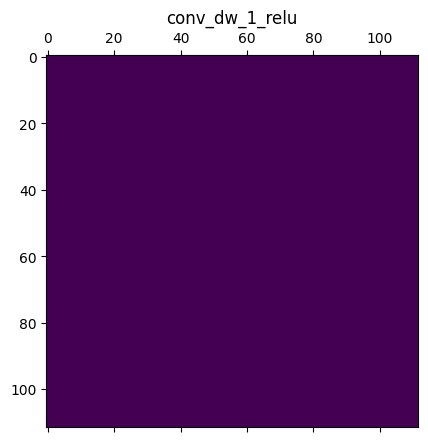

conv_pw_1 (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

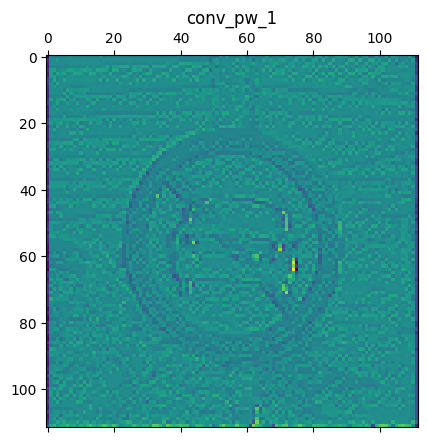

conv_pw_1_bn (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

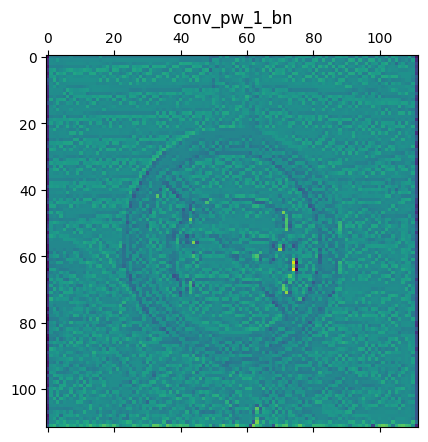

conv_pw_1_relu (1, 112, 112, 64)


<Figure size 640x480 with 0 Axes>

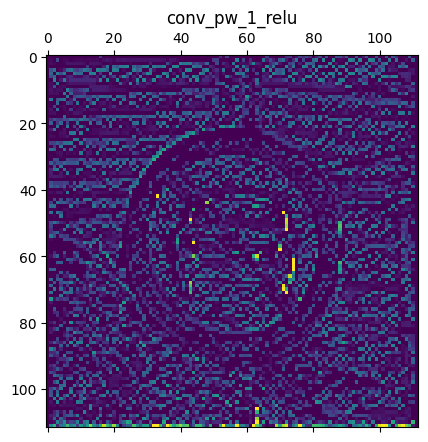

conv_pad_2 (1, 113, 113, 64)


<Figure size 640x480 with 0 Axes>

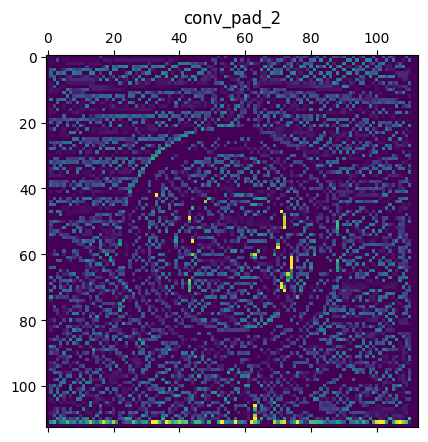

conv_dw_2 (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

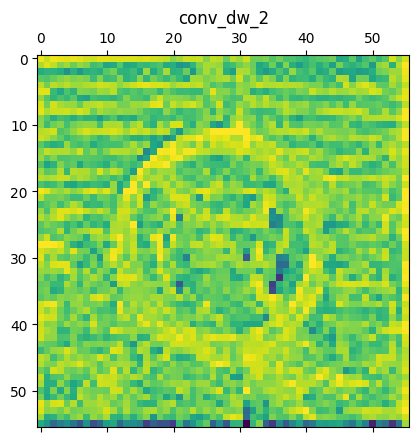

conv_dw_2_bn (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

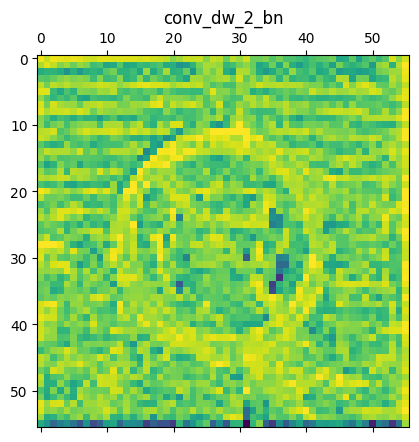

conv_dw_2_relu (1, 56, 56, 64)


<Figure size 640x480 with 0 Axes>

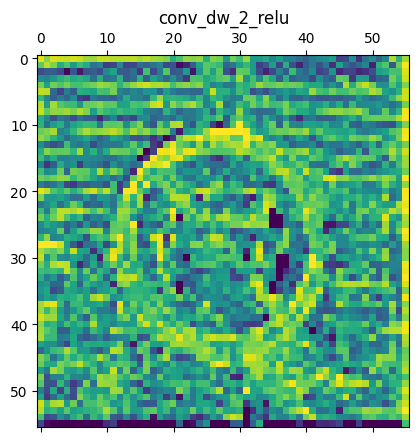

conv_pw_2 (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

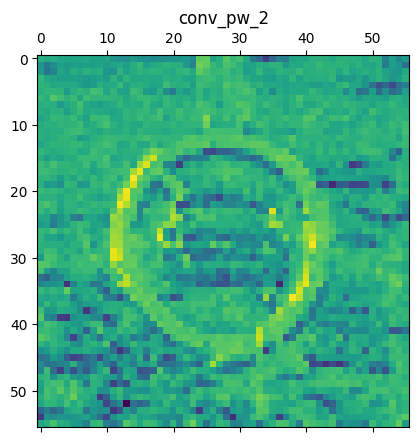

conv_pw_2_bn (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

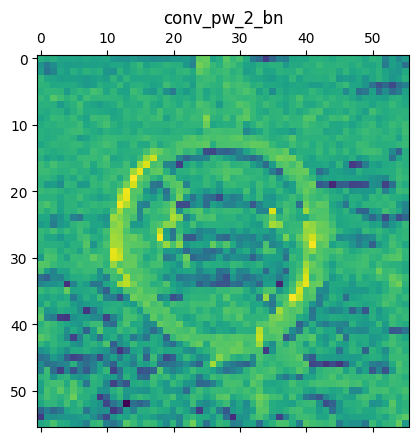

conv_pw_2_relu (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

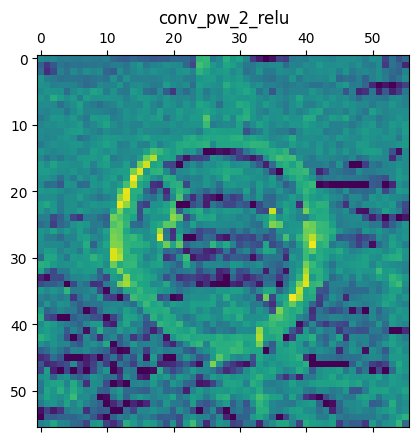

conv_dw_3 (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

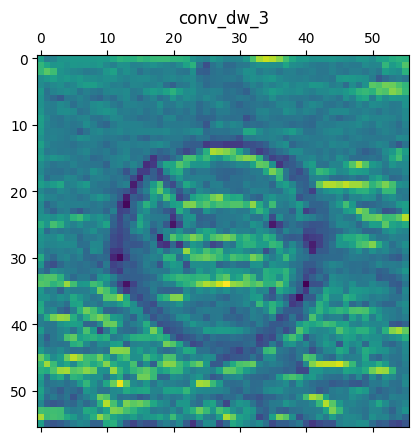

conv_dw_3_bn (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

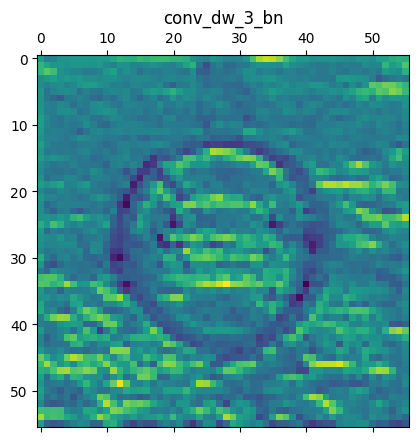

conv_dw_3_relu (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

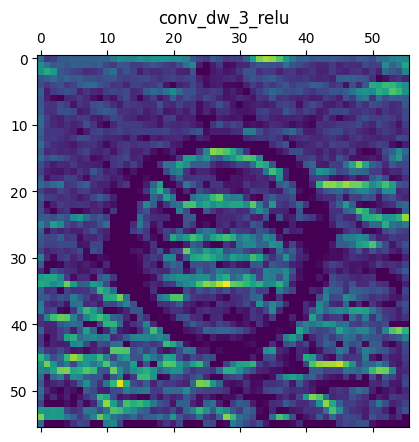

conv_pw_3 (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

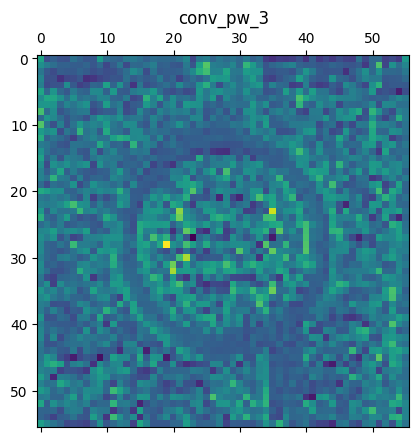

conv_pw_3_bn (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

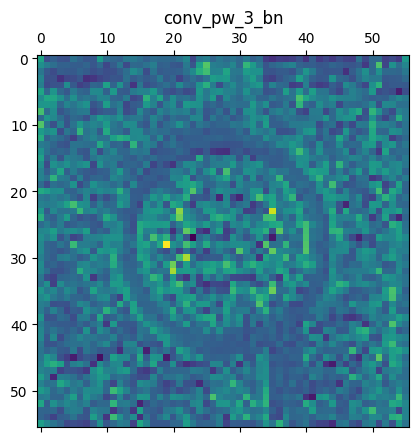

conv_pw_3_relu (1, 56, 56, 128)


<Figure size 640x480 with 0 Axes>

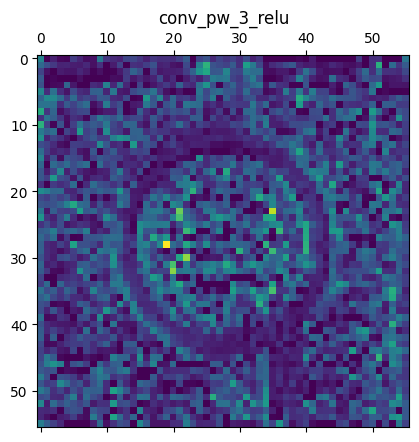

conv_pad_4 (1, 57, 57, 128)


<Figure size 640x480 with 0 Axes>

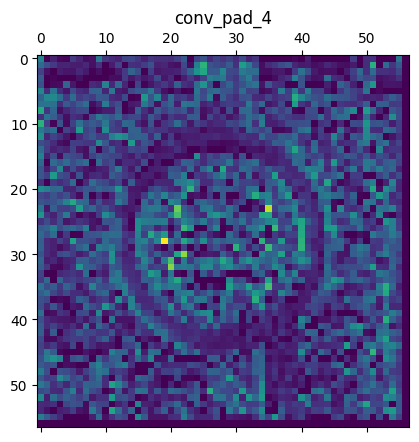

conv_dw_4 (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

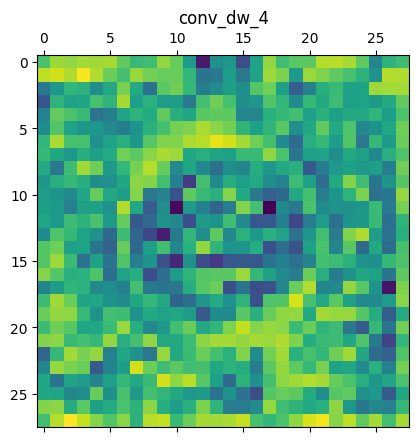

conv_dw_4_bn (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

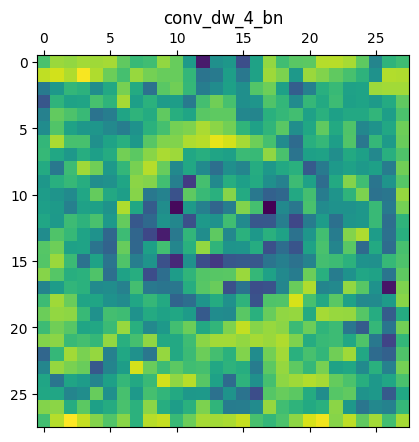

conv_dw_4_relu (1, 28, 28, 128)


<Figure size 640x480 with 0 Axes>

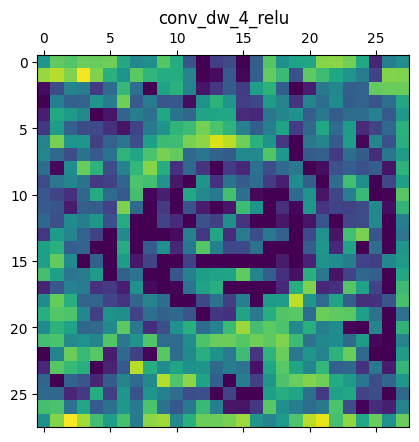

conv_pw_4 (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

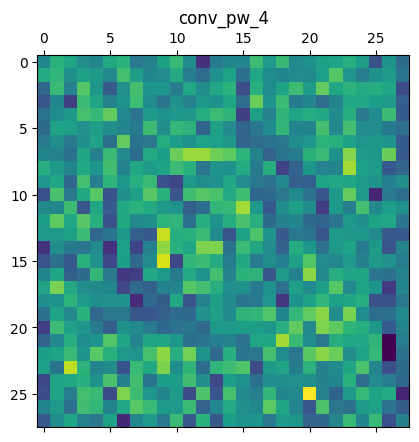

conv_pw_4_bn (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

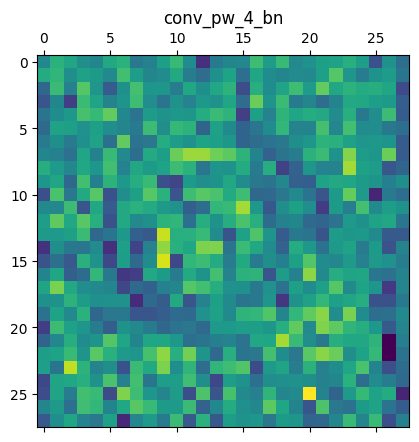

conv_pw_4_relu (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

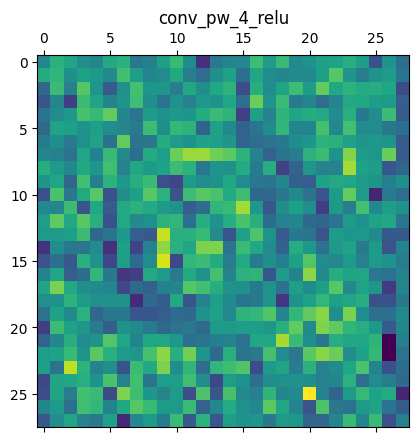

conv_dw_5 (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

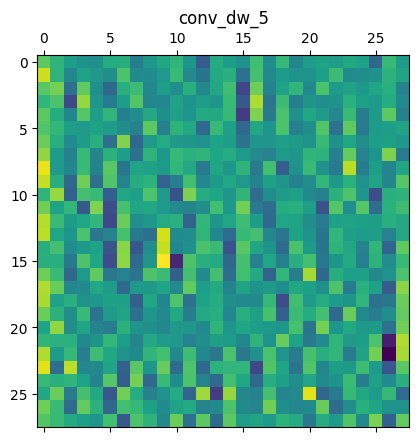

conv_dw_5_bn (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

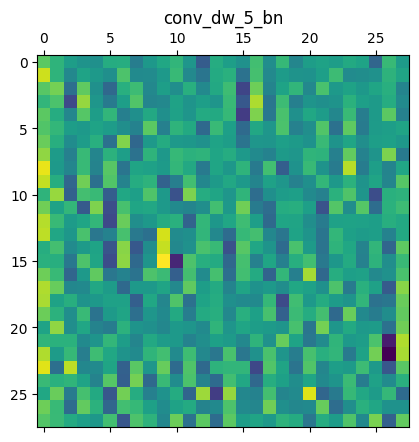

conv_dw_5_relu (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

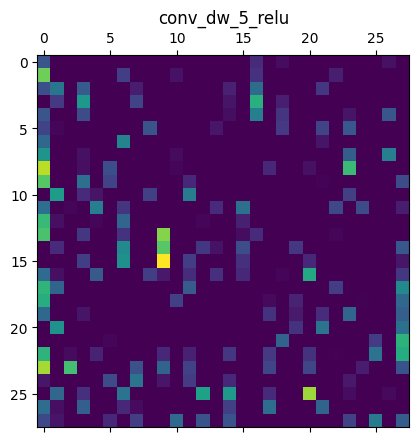

conv_pw_5 (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

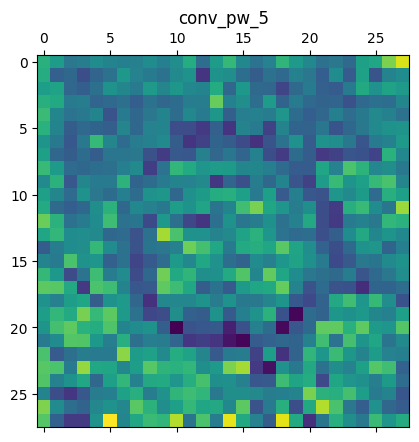

conv_pw_5_bn (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

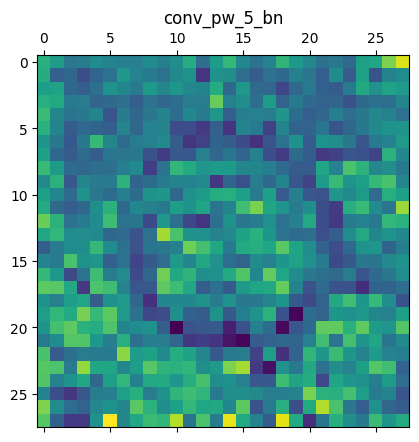

conv_pw_5_relu (1, 28, 28, 256)


<Figure size 640x480 with 0 Axes>

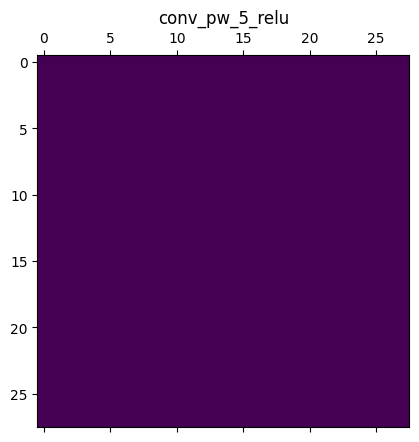

conv_pad_6 (1, 29, 29, 256)


<Figure size 640x480 with 0 Axes>

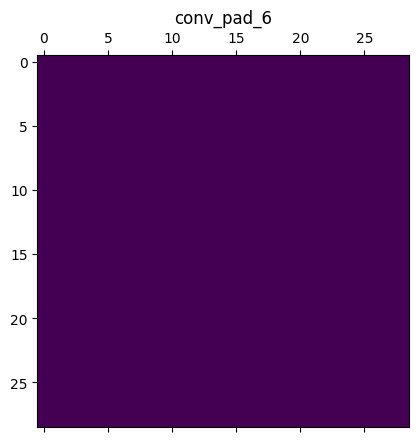

conv_dw_6 (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

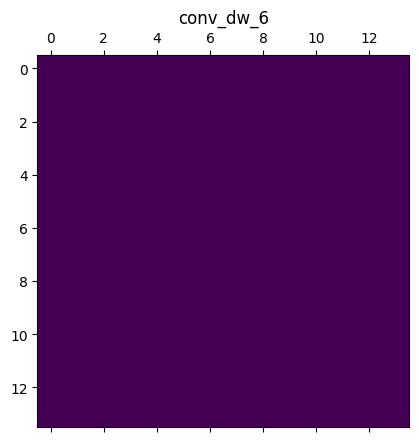

conv_dw_6_bn (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

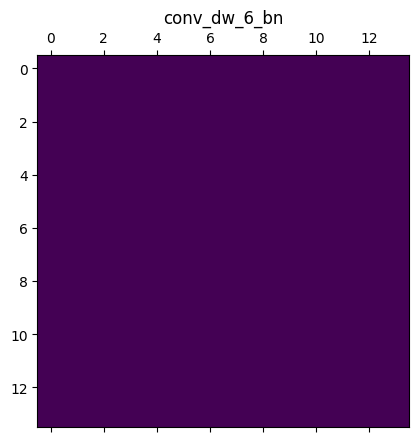

conv_dw_6_relu (1, 14, 14, 256)


<Figure size 640x480 with 0 Axes>

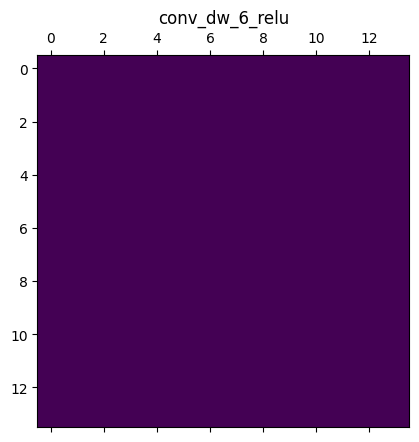

conv_pw_6 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

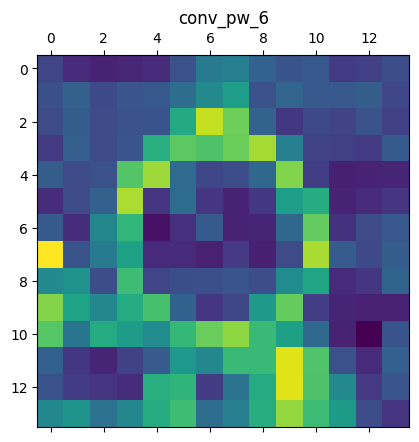

conv_pw_6_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

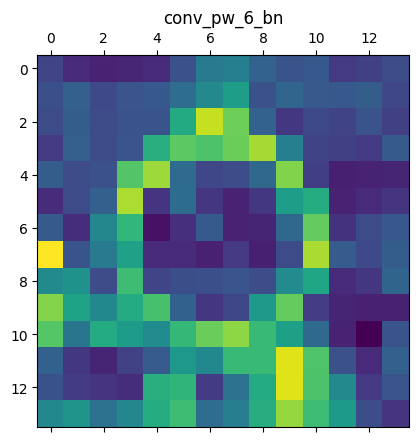

conv_pw_6_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

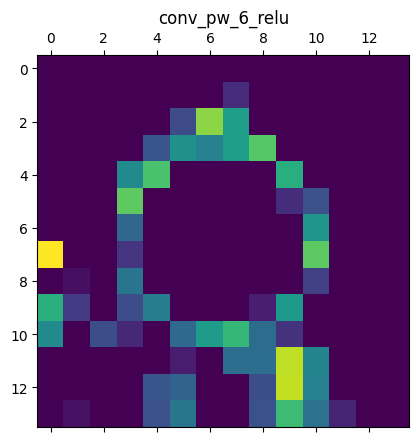

conv_dw_7 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

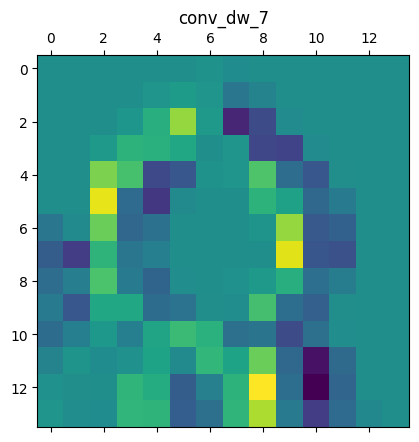

conv_dw_7_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

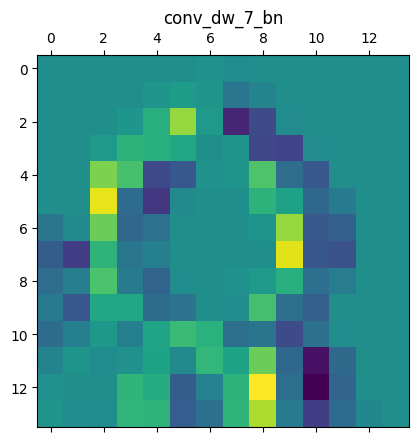

conv_dw_7_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

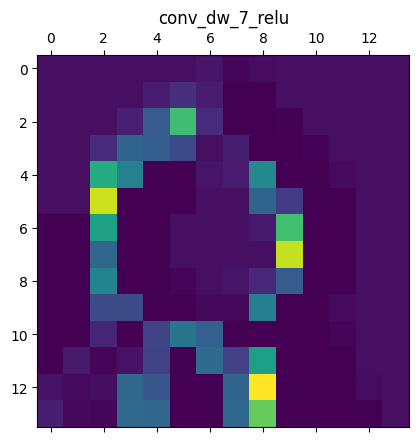

conv_pw_7 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

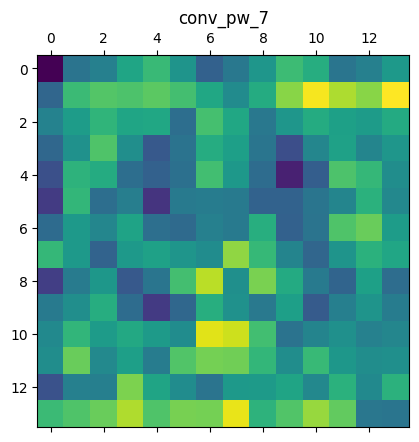

conv_pw_7_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

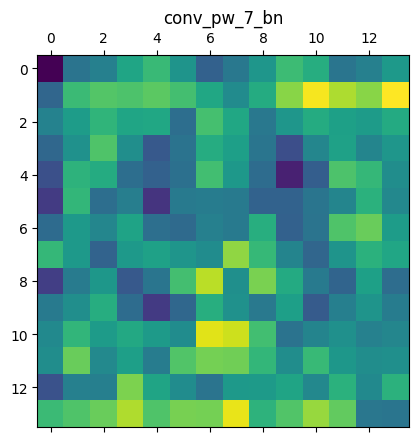

conv_pw_7_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

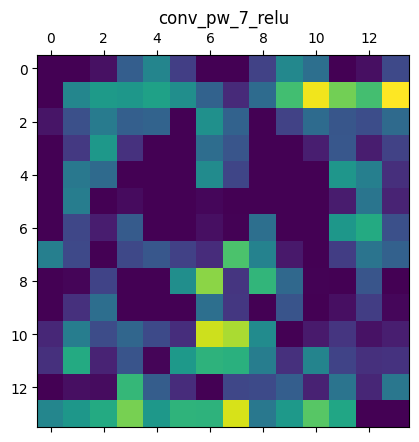

conv_dw_8 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

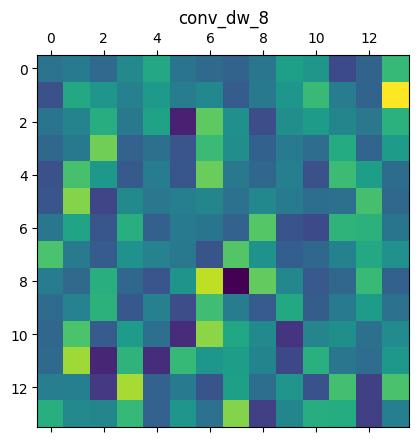

conv_dw_8_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

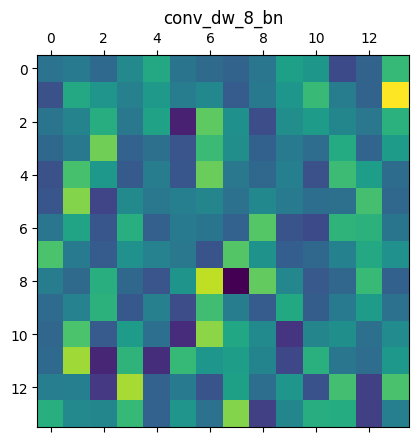

conv_dw_8_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

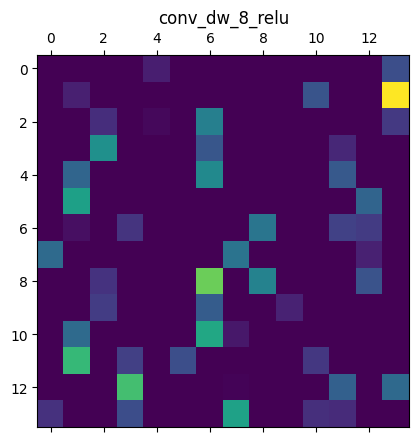

conv_pw_8 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

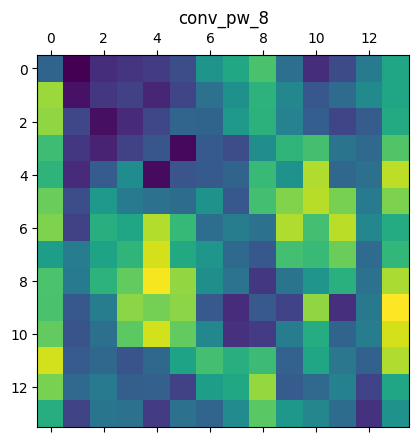

conv_pw_8_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

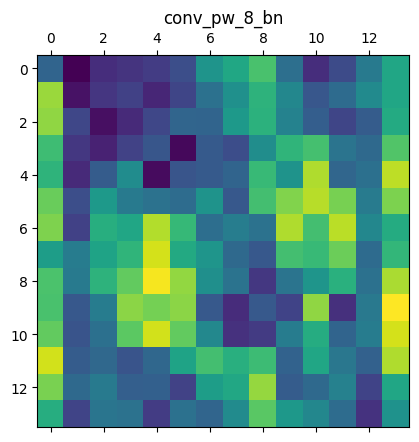

conv_pw_8_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

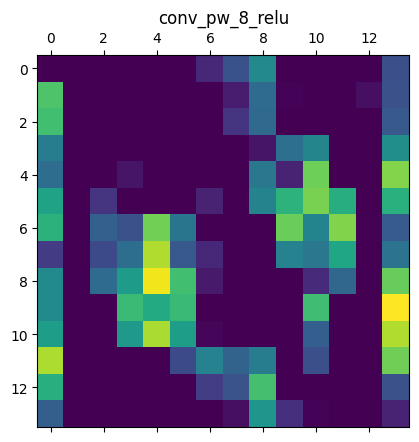

conv_dw_9 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

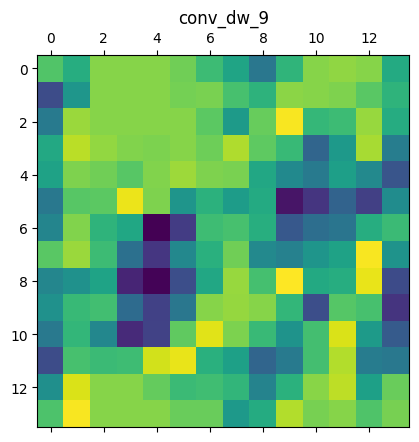

conv_dw_9_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

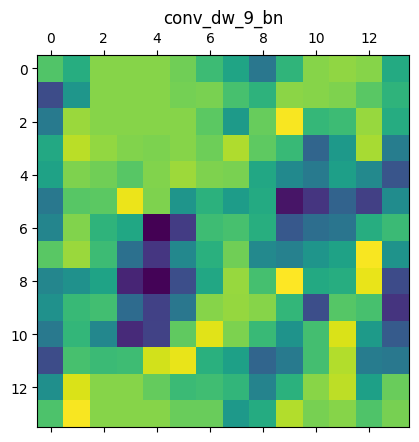

conv_dw_9_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

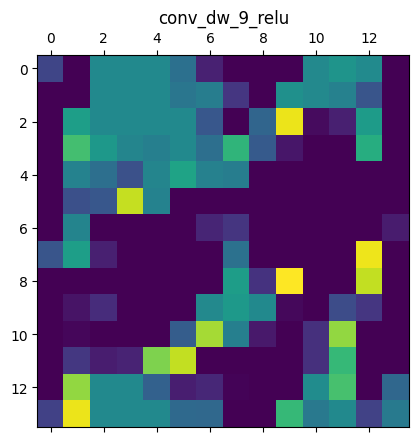

conv_pw_9 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

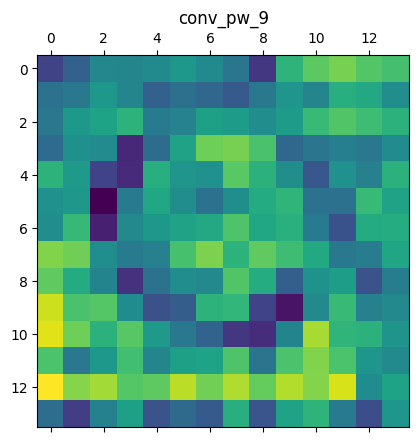

conv_pw_9_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

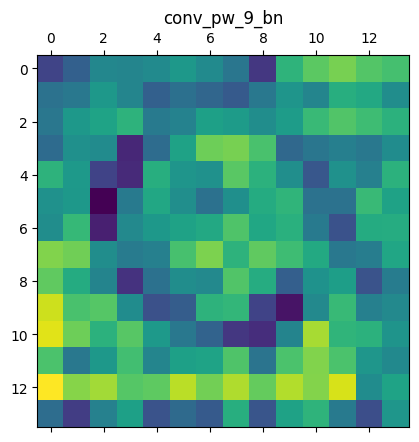

conv_pw_9_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

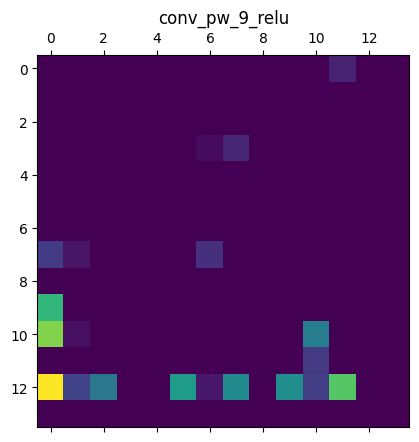

conv_dw_10 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

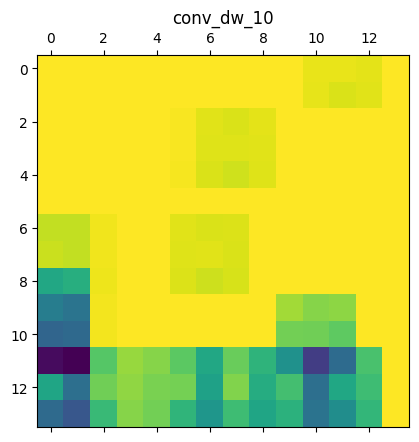

conv_dw_10_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

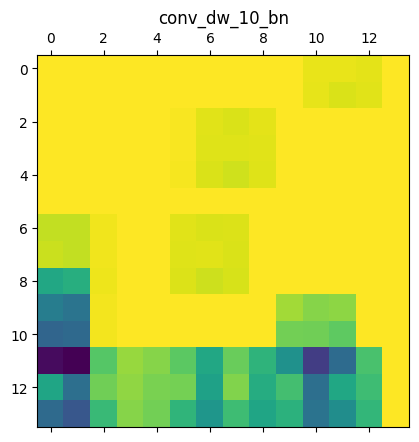

conv_dw_10_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

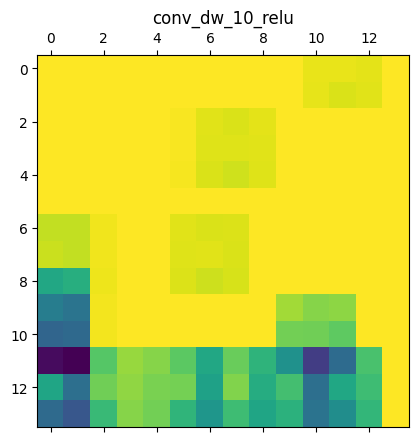

conv_pw_10 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

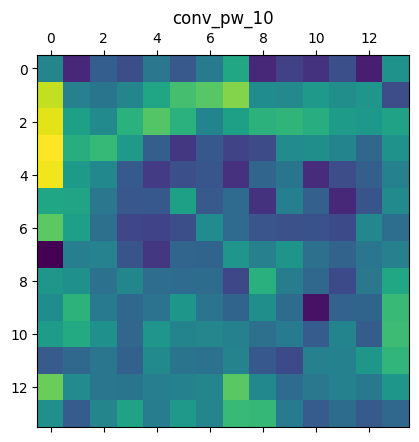

conv_pw_10_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

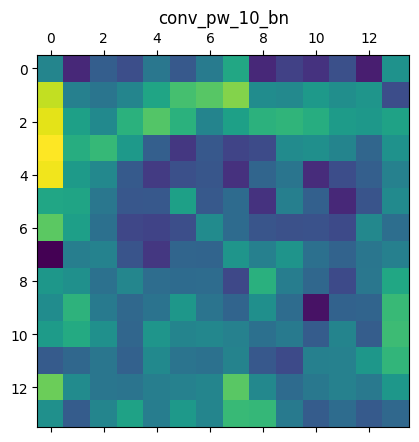

conv_pw_10_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

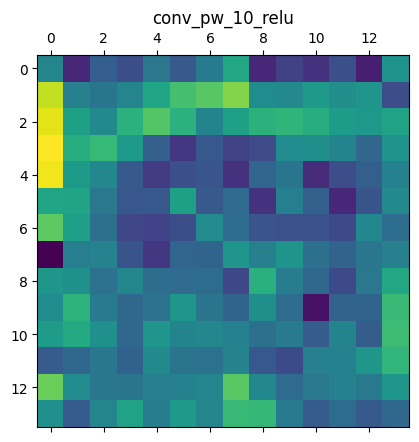

conv_dw_11 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

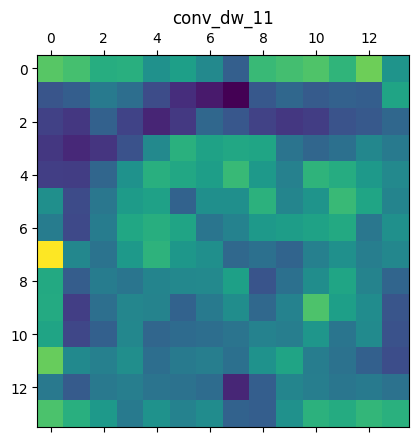

conv_dw_11_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

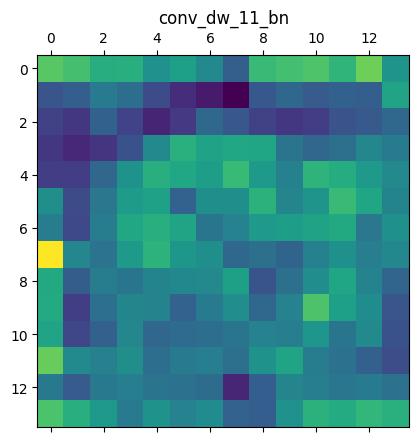

conv_dw_11_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

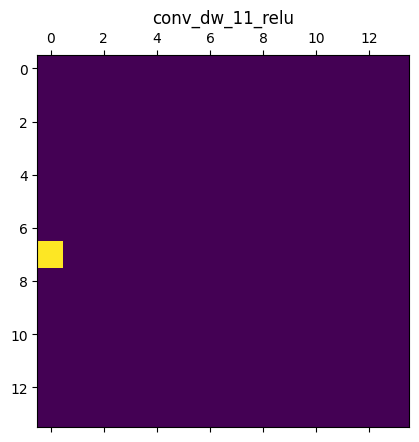

conv_pw_11 (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

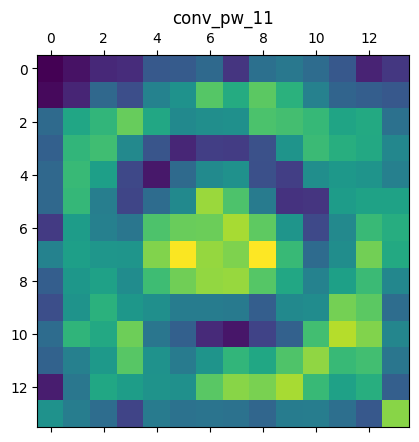

conv_pw_11_bn (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

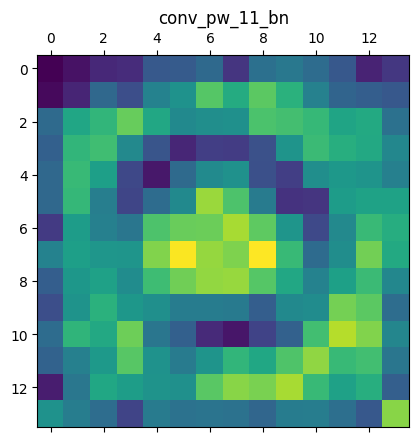

conv_pw_11_relu (1, 14, 14, 512)


<Figure size 640x480 with 0 Axes>

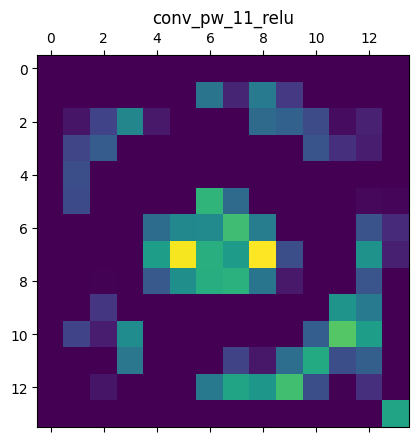

conv_pad_12 (1, 15, 15, 512)


<Figure size 640x480 with 0 Axes>

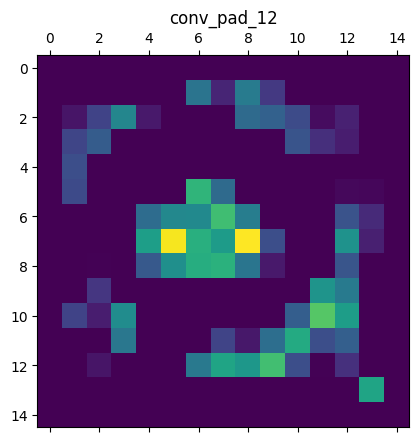

conv_dw_12 (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

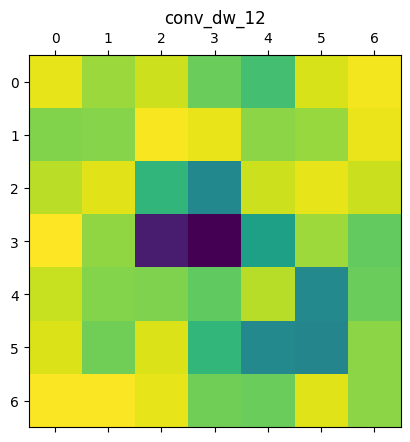

conv_dw_12_bn (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

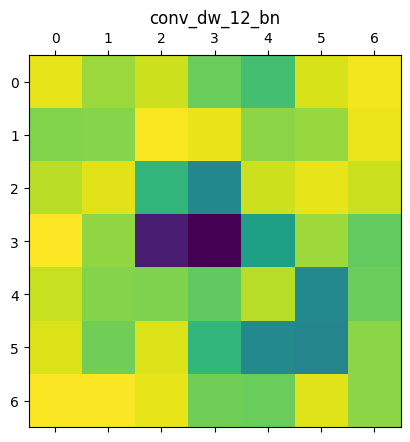

conv_dw_12_relu (1, 7, 7, 512)


<Figure size 640x480 with 0 Axes>

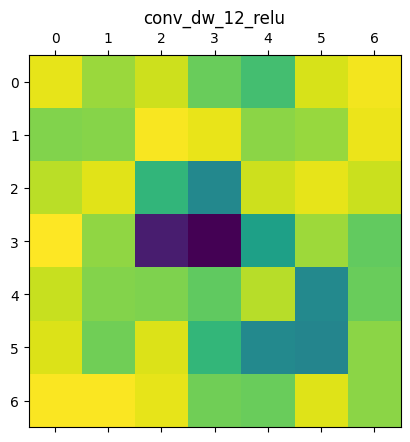

conv_pw_12 (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

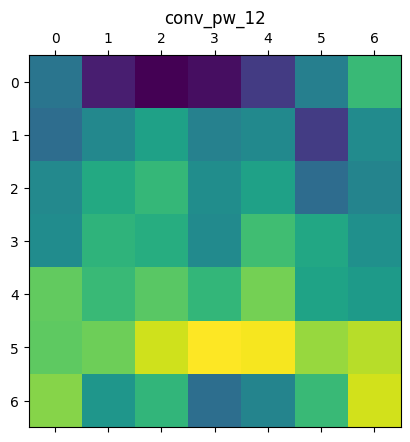

conv_pw_12_bn (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

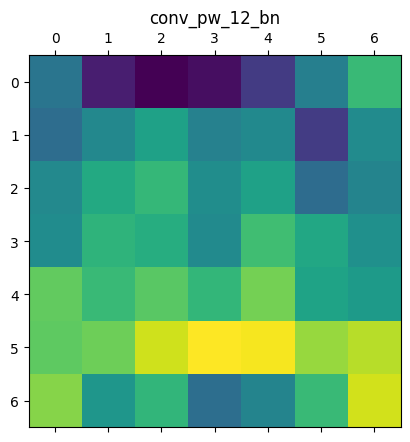

conv_pw_12_relu (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

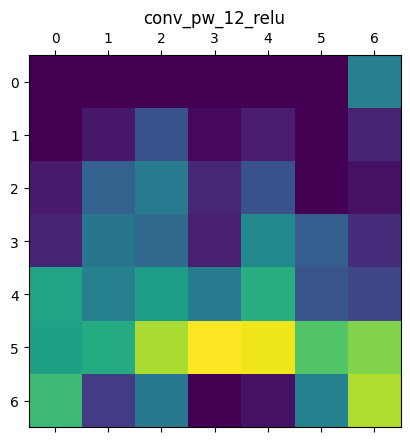

conv_dw_13 (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

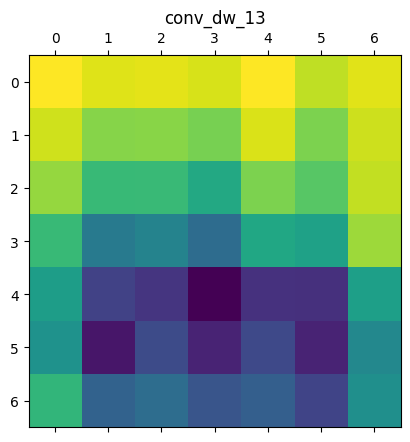

conv_dw_13_bn (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

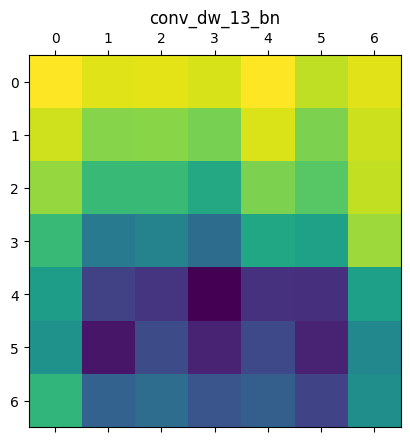

conv_dw_13_relu (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

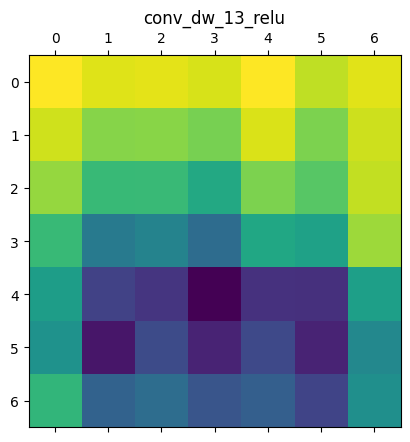

conv_pw_13 (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

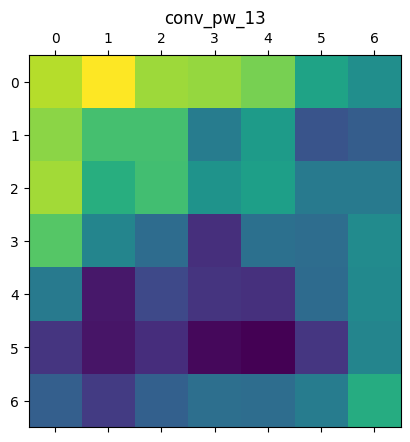

conv_pw_13_bn (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

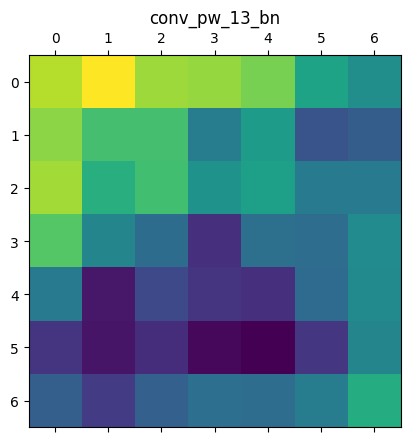

conv_pw_13_relu (1, 7, 7, 1024)


<Figure size 640x480 with 0 Axes>

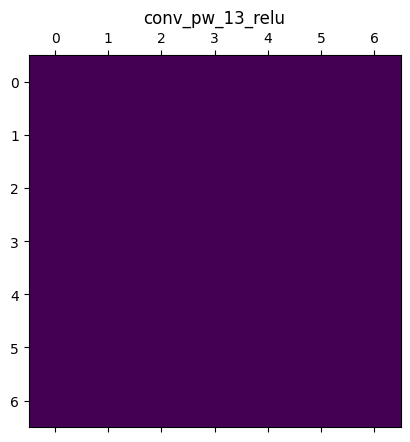

global_average_pooling2d_1 (1, 1024)
dense_2 (1, 256)
dense_3 (1, 55)


In [82]:
for layer_name, activation in zip(mobile_model.layers, activations):
    print(layer_name.name, activation.shape)
    if len(activation.shape) == 4:  # Check if the activation is of shape (batch_size, height, width, channels)
        plt.figure()
        plt.matshow(activation[0, :, :, 0], cmap='viridis')  # Visualize the first channel
        plt.title(layer_name.name)
        plt.show()

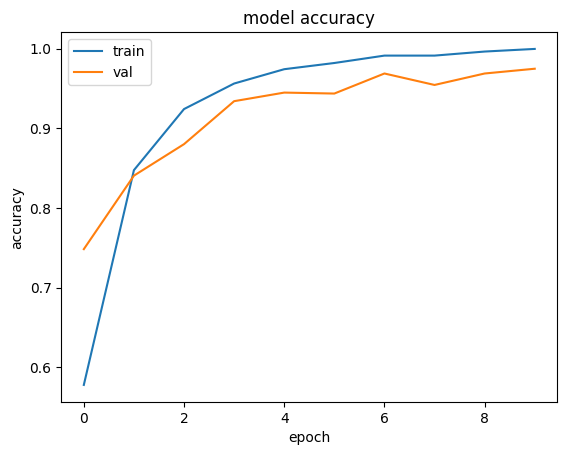

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

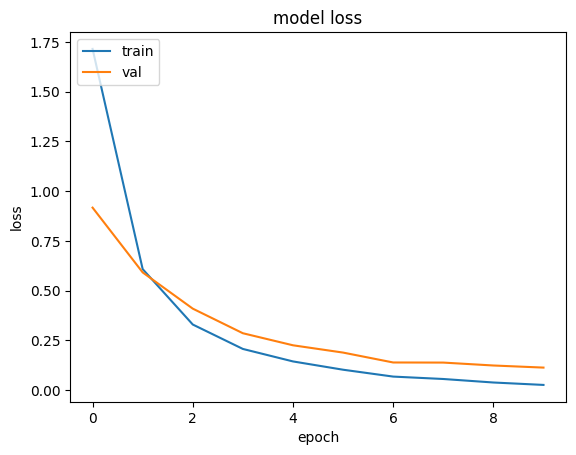

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

27/27 [==============================] - 36s 1s/step


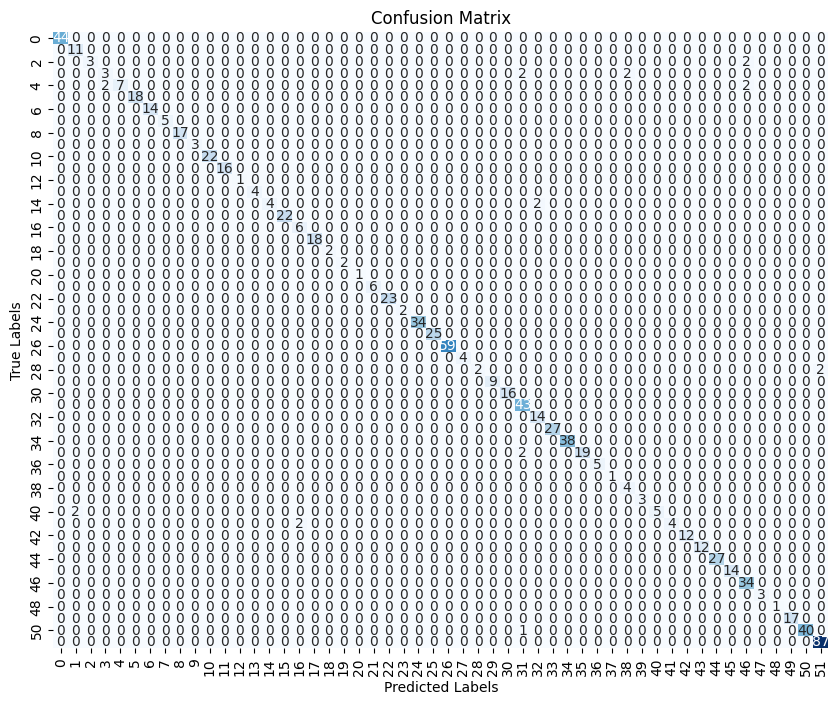

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.85      1.00      0.92        11
           2       1.00      0.60      0.75         5
           3       0.60      0.43      0.50         7
           4       1.00      0.64      0.78        11
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        17
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         4
          15       1.00      0.67      0.80         6
          16       1.00      1.00      1.00        22
          17       0.75      1.00      0.86         6
          18       1.00    

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = mobile_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test_encoded, y_pred_labels))